# YOLOv8 Training for Plume Detection

This notebook trains a YOLOv8 model on a custom plume detection dataset.
Note this was developed and ran in Colab, not locally.

**Dataset Details:**
- One bounding box per image
- Single class: "plume_source"
- Split: 80% train, 15% val, 5% test

**Why YOLO?**
- Faster training and inference than DETR
- Better for small object detection
- State-of-the-art single-stage detector
- Easier to use with Ultralytics framework
- Better for real-time applications

### Setup and Installations

In [1]:
# Remove annoying Colab folder
!rm -rf sample_data

In [2]:
# Install required packages
!pip install -q ultralytics
!pip install -q pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [3]:
# Import required libraries
import os
import shutil
import json
import zipfile
import random
from pathlib import Path
import numpy as np
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import yaml

print("Libraries imported successfully")
print(f"Ultralytics YOLO available: True")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Libraries imported successfully
Ultralytics YOLO available: True


### Mount Google Drive and Download Dataset

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path to dataset zip in Google Drive
ZIP_FILE_PATH = '/content/drive/Shareddrives/BEST Lab   Squishy Robotics URAP Root/URAP Fall 2025 - ML Software Team/Datasets/Talon - Plume Dataset/plume_images.zip'

In [7]:
# Create working directory
WORK_DIR = '/content/plume_localization'
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Working directory: {WORK_DIR}")

Working directory: /content/plume_localization


In [8]:
# Extract zip file
print(f"Extracting images from: {ZIP_FILE_PATH}")

with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(WORK_DIR)

# Setup image directory
IMAGES_DIR = os.path.join(WORK_DIR, 'images')
os.rename(
    os.path.join(WORK_DIR, 'transformed_images'),
    os.path.join(WORK_DIR, 'images')
    )

# Remove annoying directory if it exists
macosx_dir = os.path.join(WORK_DIR, '__MACOSX')
if os.path.exists(macosx_dir):
    shutil.rmtree(macosx_dir)

print(f"Images directory: {IMAGES_DIR}")

Extracting images from: /content/drive/Shareddrives/BEST Lab   Squishy Robotics URAP Root/URAP Fall 2025 - ML Software Team/Datasets/Talon - Plume Dataset/plume_images.zip
Images directory: /content/plume_localization/images


### Load and Parse Annotations

In [14]:
# Load custom JSON annotations
ANNOTATIONS_FILE = os.path.join(IMAGES_DIR, 'labels.json')

with open(ANNOTATIONS_FILE, 'r') as f:
    annotations_data = json.load(f)

print(f"Loaded annotations from: {ANNOTATIONS_FILE}")
print(f"Number of annotations: {len(annotations_data)}")
print(f"\nSample annotation:")
print(json.dumps(annotations_data[0], indent=2))

Loaded annotations from: /content/plume_localization/images/labels.json
Number of annotations: 17361

Sample annotation:
{
  "image_name": "MOV_1237_plume_frame_000001_trans11_0.png",
  "image_path": "source_localization/dataset/plume_image_dataset/transformed_images/MOV_1237_plume_frame_000001_trans11_0.png",
  "image_size": [
    320,
    240
  ],
  "image_channels": 3,
  "image_format": "png",
  "bbox": [
    181,
    120,
    20,
    10
  ],
  "bbox_format": "xywh",
  "rotation": 0,
  "rotation_format": "degrees",
  "translation": [
    11,
    0
  ]
}


In [15]:
def parse_custom_annotations(annotations_data, images_dir):
    """
    Parse custom JSON annotations and create structured list.
    Returns list of dicts with image info and bounding boxes.
    """
    annotations_list = []

    for idx, ann in enumerate(annotations_data):
        # Extract image info
        image_name = ann['image_name']
        image_size = ann['image_size']  # [width, height]
        bbox = ann['bbox']  # [x, y, width, height] - top-left corner format

        annotation = {
            'image_id': idx,
            'image_name': image_name,
            'local_image_path': os.path.join(images_dir, image_name),
            'width': image_size[0],
            'height': image_size[1],
            'bbox': bbox,  # [x, y, width, height] - top-left corner
            'category_id': 0,  # Single class: plume_source
            'category_name': 'plume_source',
            'rotation': ann.get('rotation', 0),
            'translation': ann.get('translation', [0, 0])
        }

        annotations_list.append(annotation)

    return annotations_list

# Parse annotations
annotations = parse_custom_annotations(annotations_data, IMAGES_DIR)

print(f"\nParsed {len(annotations)} annotations")
print(f"\nProcessed annotation structure:")
print(json.dumps(annotations[0], indent=2))


Parsed 17361 annotations

Processed annotation structure:
{
  "image_id": 0,
  "image_name": "MOV_1237_plume_frame_000001_trans11_0.png",
  "local_image_path": "/content/plume_localization/images/MOV_1237_plume_frame_000001_trans11_0.png",
  "width": 320,
  "height": 240,
  "bbox": [
    181,
    120,
    20,
    10
  ],
  "category_id": 0,
  "category_name": "plume_source",
  "rotation": 0,
  "translation": [
    11,
    0
  ]
}


### Split Dataset into Train/Val/Test

In [16]:
# Shuffle and split the annotations
random.seed(42)
random.shuffle(annotations)

total = len(annotations)
train_size = int(0.80 * total)
val_size = int(0.15 * total)

train_annotations = annotations[:train_size]
val_annotations = annotations[train_size:train_size + val_size]
test_annotations = annotations[train_size + val_size:]

print(f"Dataset Split:")
print(f"  Train: {len(train_annotations)} images ({len(train_annotations)/total*100:.1f}%)")
print(f"  Val:   {len(val_annotations)} images ({len(val_annotations)/total*100:.1f}%)")
print(f"  Test:  {len(test_annotations)} images ({len(test_annotations)/total*100:.1f}%)")

Dataset Split:
  Train: 13888 images (80.0%)
  Val:   2604 images (15.0%)
  Test:  869 images (5.0%)


### Convert to YOLO Format

YOLO expects:
- Images in `images/train`, `images/val`, `images/test`
- Labels in `labels/train`, `labels/val`, `labels/test`
- Label format: `class_id center_x center_y width height` (normalized 0-1)

In [17]:
def coco_to_yolo_bbox(bbox, img_width, img_height):
    """
    Convert COCO bbox [x, y, width, height] to YOLO format.
    YOLO format: [center_x, center_y, width, height] normalized to [0, 1]
    """
    x, y, w, h = bbox

    # Calculate center coordinates
    center_x = (x + w / 2) / img_width
    center_y = (y + h / 2) / img_height

    # Normalize width and height
    norm_w = w / img_width
    norm_h = h / img_height

    return center_x, center_y, norm_w, norm_h

def create_yolo_dataset(annotations_list, split_name, dataset_root):
    """
    Create YOLO format dataset structure.
    """
    # Create directories
    images_dir = os.path.join(dataset_root, 'images', split_name)
    labels_dir = os.path.join(dataset_root, 'labels', split_name)
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for ann in annotations_list:
        # Copy image
        src_image = ann['local_image_path']
        dst_image = os.path.join(images_dir, ann['image_name'])
        shutil.copy2(src_image, dst_image)

        # Create label file
        label_filename = os.path.splitext(ann['image_name'])[0] + '.txt'
        label_path = os.path.join(labels_dir, label_filename)

        # Convert bbox to YOLO format
        yolo_bbox = coco_to_yolo_bbox(
            ann['bbox'],
            ann['width'],
            ann['height']
        )

        # Write label file: class_id center_x center_y width height
        with open(label_path, 'w') as f:
            f.write(f"{ann['category_id']} {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")

    print(f"Created {split_name} split: {len(annotations_list)} images")

# Create YOLO dataset
YOLO_DATASET_ROOT = os.path.join(WORK_DIR, 'yolo_dataset')
os.makedirs(YOLO_DATASET_ROOT, exist_ok=True)

print("Creating YOLO dataset structure...")
create_yolo_dataset(train_annotations, 'train', YOLO_DATASET_ROOT)
create_yolo_dataset(val_annotations, 'val', YOLO_DATASET_ROOT)
create_yolo_dataset(test_annotations, 'test', YOLO_DATASET_ROOT)
print("YOLO dataset created successfully")

Creating YOLO dataset structure...
Created train split: 13888 images
Created val split: 2604 images
Created test split: 869 images
✓ YOLO dataset created successfully


In [18]:
# Create YOLO data.yaml configuration file
data_yaml = {
    'path': YOLO_DATASET_ROOT,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 1,  # number of classes
    'names': ['plume_source']  # class names
}

data_yaml_path = os.path.join(YOLO_DATASET_ROOT, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"✓ Created data.yaml at: {data_yaml_path}")
print("\nConfiguration:")
print(yaml.dump(data_yaml, default_flow_style=False))

✓ Created data.yaml at: /content/plume_localization/yolo_dataset/data.yaml

Configuration:
names:
- plume_source
nc: 1
path: /content/plume_localization/yolo_dataset
test: images/test
train: images/train
val: images/val



### Visualize Dataset Samples

Training samples:


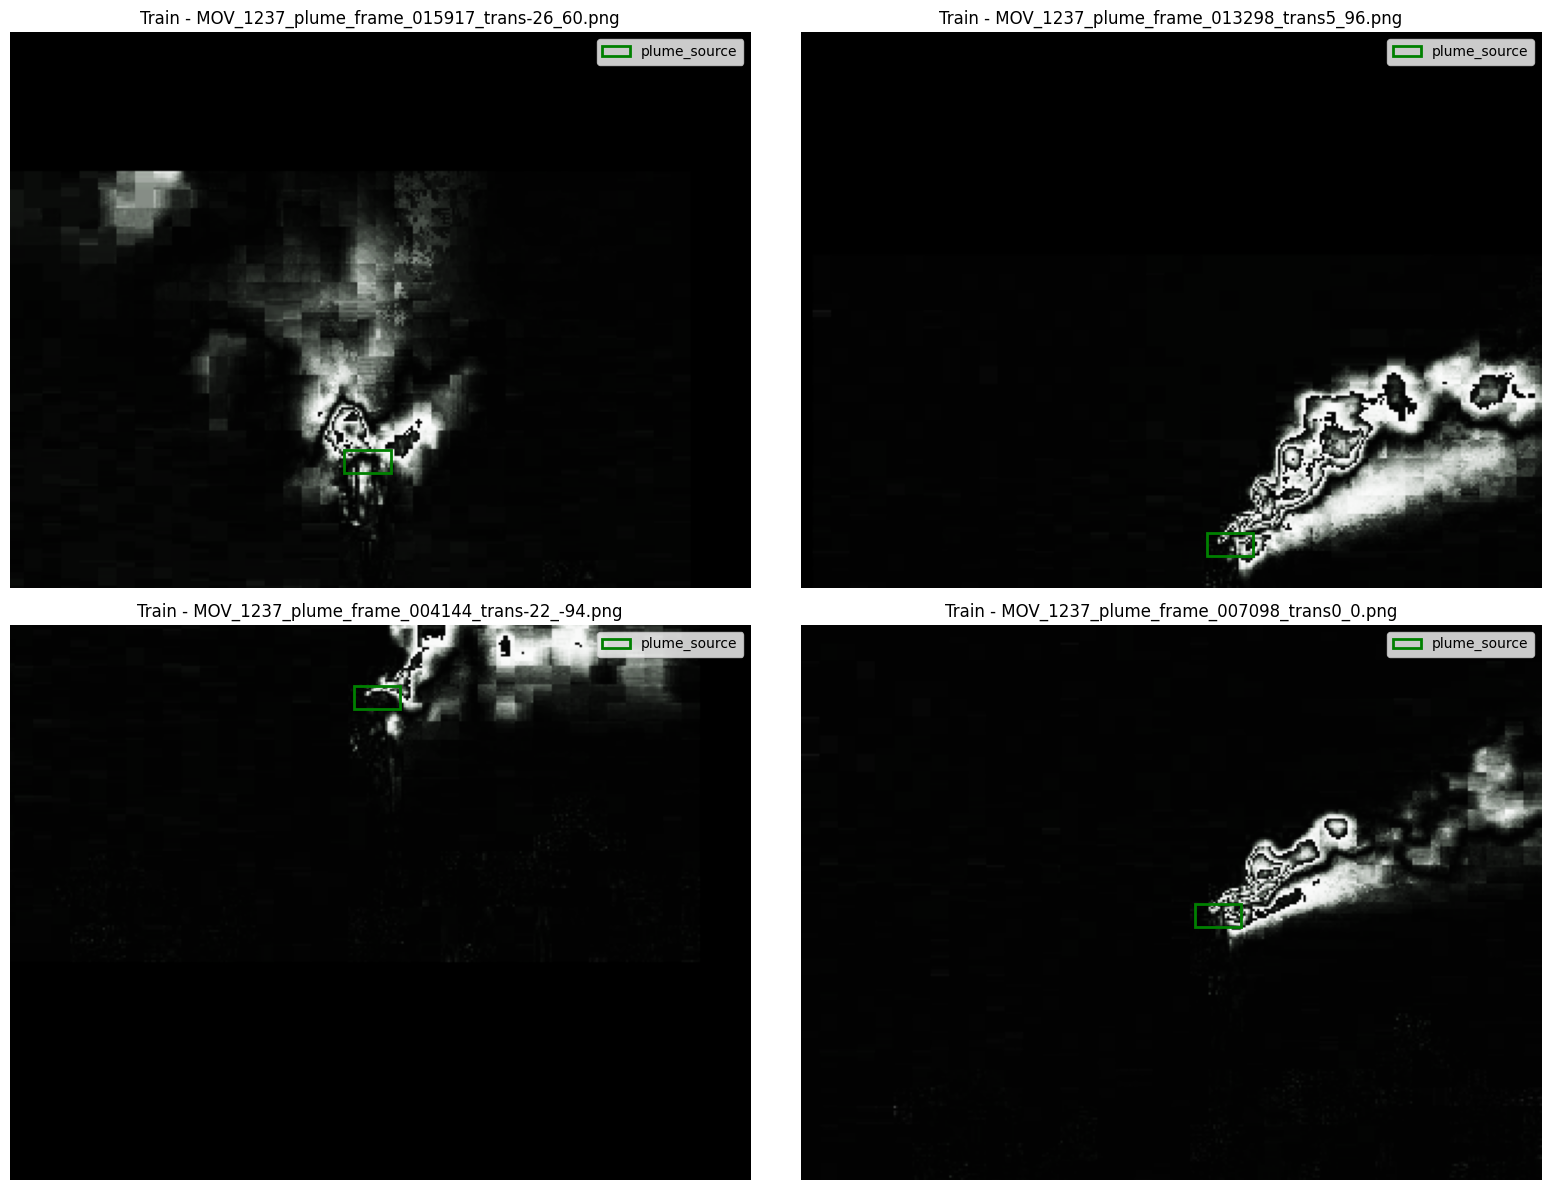

In [19]:
def visualize_yolo_annotations(dataset_root, split='train', num_samples=4):
    """
    Visualize YOLO format annotations.
    """
    images_dir = os.path.join(dataset_root, 'images', split)
    labels_dir = os.path.join(dataset_root, 'labels', split)

    # Get random samples
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(samples):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Load label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)

        # Display image
        axes[idx].imshow(image)

        # Read and draw bounding boxes
        with open(label_path, 'r') as f:
            for line in f:
                class_id, cx, cy, w, h = map(float, line.strip().split())

                # Convert YOLO format back to pixel coordinates
                x1 = (cx - w/2) * width
                y1 = (cy - h/2) * height
                box_w = w * width
                box_h = h * height

                # Draw rectangle
                rect = patches.Rectangle(
                    (x1, y1), box_w, box_h,
                    linewidth=2,
                    edgecolor='green',
                    facecolor='none',
                    label='plume_source'
                )
                axes[idx].add_patch(rect)

        axes[idx].set_title(f"{split.capitalize()} - {img_file}")
        axes[idx].legend(loc='upper right')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training samples:")
visualize_yolo_annotations(YOLO_DATASET_ROOT, 'train', num_samples=4)

### Train YOLOv8 Model

In [20]:
# Initialize YOLOv8 model
# Options: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium), yolov8l.pt (large), yolov8x.pt (extra large)
# Using yolov8s.pt as a good balance between speed and accuracy
model = YOLO('yolov8s.pt')

print("YOLOv8 model loaded")

YOLOv8 model loaded


In [21]:
# Train the model
results = model.train(
    data=data_yaml_path,
    epochs=5,
    imgsz=640,
    batch=16,
    name='plume_detection_yolov8',
    patience=10,  # Early stopping patience
    save=True,
    device=0,  # Use GPU 0
    workers=4,
    optimizer='AdamW',
    lr0=0.001,  # Initial learning rate
    lrf=0.01,   # Final learning rate factor
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,  # Box loss gain
    cls=0.5,  # Class loss gain
    dfl=1.5,  # DFL loss gain
    plots=True,  # Save plots
    save_period=10  # Save checkpoint every 10 epochs
)

print("\n Training completed!")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/plume_localization/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plume_detection_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10,

### Evaluate Model

In [22]:
# Validate the model on validation set
metrics = model.val(
    data=data_yaml_path,
    split='val',
    imgsz=640,
    batch=16,
    conf=0.25,  # Confidence threshold
    iou=0.6,    # IoU threshold for NMS
    plots=True
)

print("\nValidation Metrics:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 796.6±339.5 MB/s, size: 44.7 KB)
val: Scanning /content/plume_localization/yolo_dataset/labels/val.cache... 2604 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2604/2604 4.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 163/163 5.9it/s 27.7s
                   all       2604       2604      0.999          1      0.995      0.984
Speed: 0.8ms preprocess, 6.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val

Validation Metrics:
  mAP50: 0.9950
  mAP50-95: 0.9843
  Precision: 0.9992
  Recall: 0.9996


In [23]:
# Evaluate on test set
test_metrics = model.val(
    data=data_yaml_path,
    split='test',
    imgsz=640,
    batch=16,
    conf=0.25,
    iou=0.6,
    plots=True
)

print("\nTest Set Metrics:")
print(f"  mAP50: {test_metrics.box.map50:.4f}")
print(f"  mAP50-95: {test_metrics.box.map:.4f}")
print(f"  Precision: {test_metrics.box.mp:.4f}")
print(f"  Recall: {test_metrics.box.mr:.4f}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 885.8±287.8 MB/s, size: 35.8 KB)
val: Scanning /content/plume_localization/yolo_dataset/labels/test... 869 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 869/869 2.4Kit/s 0.4s
val: New cache created: /content/plume_localization/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 55/55 5.1it/s 10.7s
                   all        869        869          1          1      0.995      0.985
Speed: 1.3ms preprocess, 6.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val2

Test Set Metrics:
  mAP50: 0.9950
  mAP50-95: 0.9849
  Precision: 1.0000
  Recall: 1.0000


### Visualize Predictions

Predictions on test set:


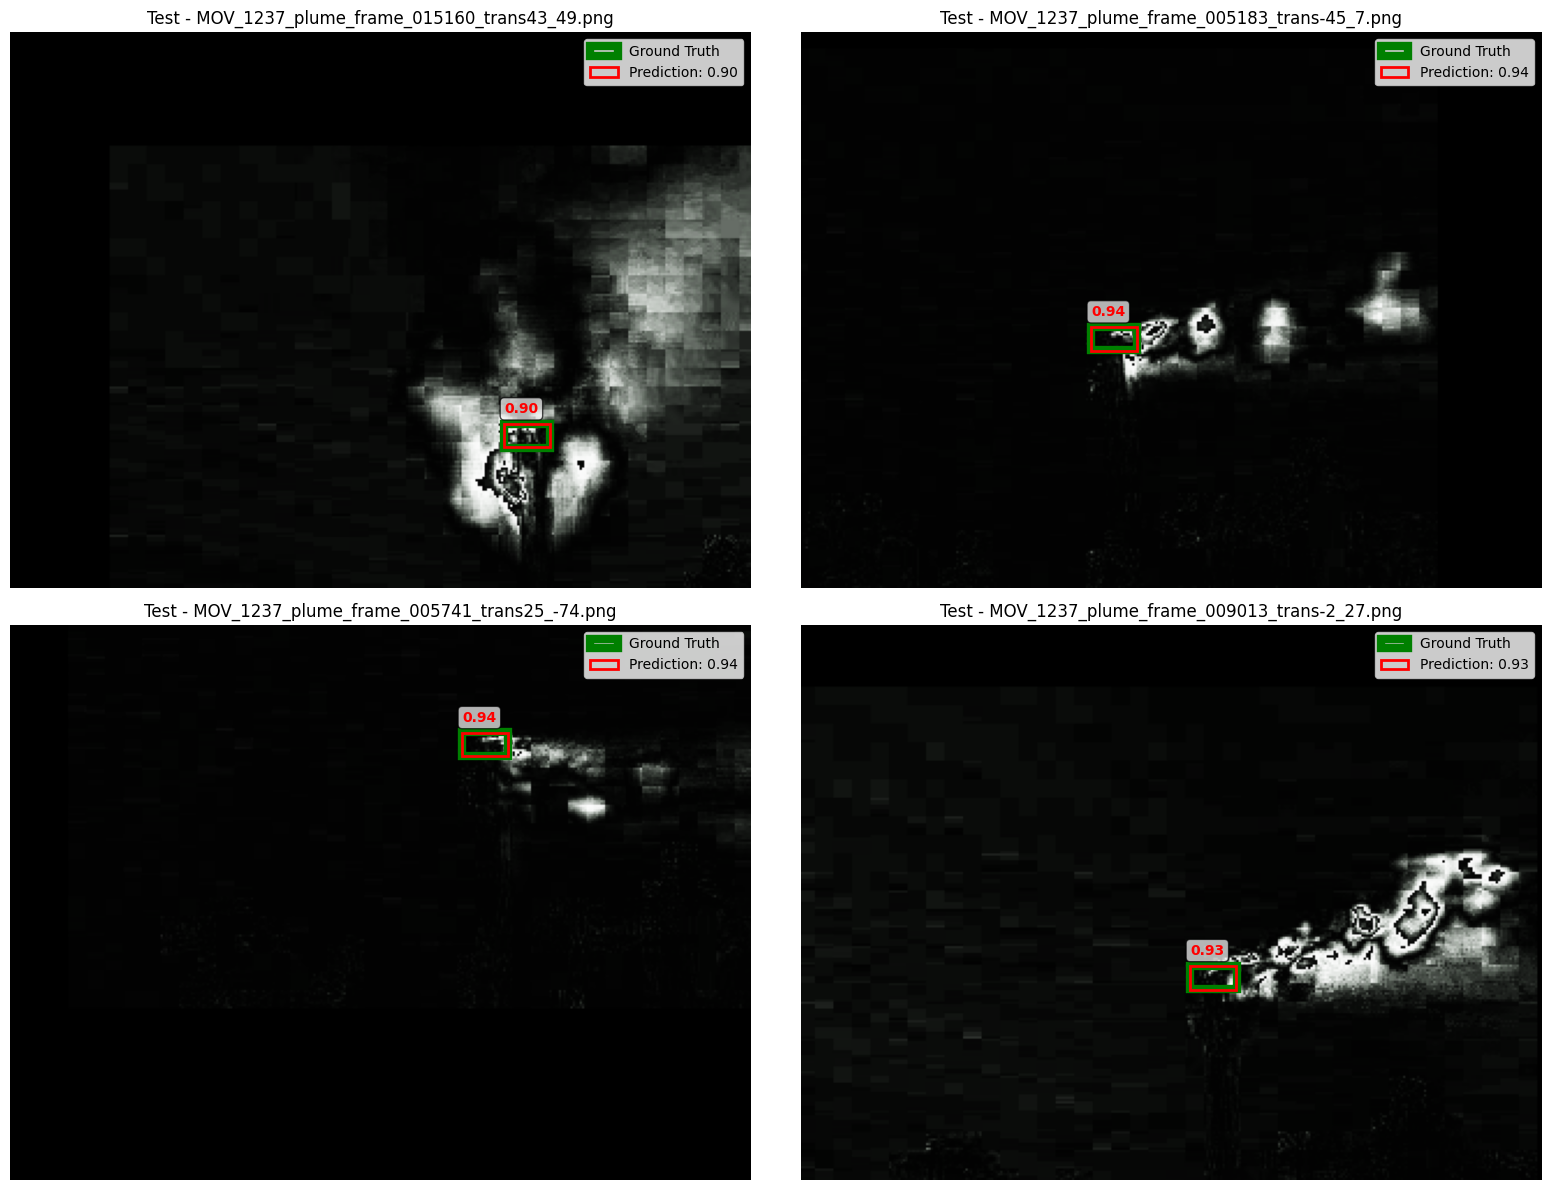

In [27]:
def visualize_predictions(model, dataset_root, split='test', num_samples=4, conf_threshold=0.25):
    """
    Visualize model predictions vs ground truth.
    """
    images_dir = os.path.join(dataset_root, 'images', split)
    labels_dir = os.path.join(dataset_root, 'labels', split)

    # Get random samples
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(samples):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        # Run prediction
        results = model.predict(img_path, conf=conf_threshold, verbose=False)

        # Display image
        axes[idx].imshow(image)

        # Draw ground truth (green)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)

        with open(label_path, 'r') as f:
            for line in f:
                class_id, cx, cy, w, h = map(float, line.strip().split())

                # Convert to pixel coordinates
                x1 = (cx - w/2) * width
                y1 = (cy - h/2) * height
                box_w = w * width
                box_h = h * height

                rect = patches.Rectangle(
                    (x1, y1), box_w, box_h,
                    linewidth=6,
                    edgecolor='green',
                    facecolor='none',
                    label='Ground Truth'
                )
                axes[idx].add_patch(rect)

        # Draw predictions (red)
        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Get box coordinates
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()

                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none',
                    label=f'Prediction: {conf:.2f}'
                )
                axes[idx].add_patch(rect)

                # Add confidence text
                axes[idx].text(
                    x1, y1-5,
                    f'{conf:.2f}',
                    color='red',
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
                )

        axes[idx].set_title(f"{split.capitalize()} - {img_file}")
        axes[idx].legend(loc='upper right')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
print("Predictions on test set:")
visualize_predictions(model, YOLO_DATASET_ROOT, 'test', num_samples=4, conf_threshold=0.25)

### Export Model

In [28]:
# Export model to different formats
# The trained model is automatically saved in runs/detect/plume_detection_yolov8/weights/best.pt

# Load best model
best_model_path = 'runs/detect/plume_detection_yolov8/weights/best.pt'
model = YOLO(best_model_path)

print(f"Loaded best model from: {best_model_path}")

# Export to ONNX format (for production deployment)
onnx_path = model.export(format='onnx', imgsz=640)
print(f"Exported to ONNX: {onnx_path}")

# You can also export to other formats:
# model.export(format='torchscript')  # TorchScript
# model.export(format='coreml')       # CoreML for iOS
# model.export(format='tflite')       # TensorFlow Lite
# model.export(format='engine')       # TensorRT

Loaded best model from: runs/detect/plume_detection_yolov8/weights/best.pt
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/plume_detection_yolov8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 8.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 11.0s, saved as 'runs/detect/plume_detection_yolov8/weights/best.onnx' (42.7 MB)

Ex

### Save Model to Google Drive

In [29]:
# Copy best model to Google Drive
drive_save_dir = '/content/drive/MyDrive/plume_yolo_models'
os.makedirs(drive_save_dir, exist_ok=True)

# Copy best weights
shutil.copy2(
    best_model_path,
    os.path.join(drive_save_dir, 'yolov8s_plume_best.pt')
)

# Copy data.yaml
shutil.copy2(
    data_yaml_path,
    os.path.join(drive_save_dir, 'data.yaml')
)

print(f"Model saved to Google Drive: {drive_save_dir}")
print("  - yolov8s_plume_best.pt")
print("  - data.yaml")

Model saved to Google Drive: /content/drive/MyDrive/plume_yolo_models
  - yolov8s_plume_best.pt
  - data.yaml


In [38]:
# Copy the plume yolo dataset to Google Drive
shutil.copytree(
    os.path.join(WORK_DIR, 'yolo_dataset'),
    os.path.join(drive_save_dir, 'plume_source_yolo_dataset')
)

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/plume_yolo_models/plume_source_yolo_dataset'

### Optional: Push to HuggingFace Hub

In [37]:
# Install huggingface_hub if you want to push to HF
!pip install -q huggingface_hub

from huggingface_hub import HfApi, create_repo
from huggingface_hub import notebook_login

# Login to HuggingFace
notebook_login()

# Configuration
HF_USERNAME = "TalonMeyer"  # Replace with your HuggingFace username
MODEL_NAME = "yolov8-plume-detection"
REPO_ID = f"{HF_USERNAME}/{MODEL_NAME}"

# Create repository
try:
    create_repo(REPO_ID, exist_ok=True)
    print(f"Repository created: {REPO_ID}")
except:
    print(f"Repository {REPO_ID} already exists")

# Upload model files
api = HfApi()

# Upload best model
api.upload_file(
    path_or_fileobj=best_model_path,
    path_in_repo="best.pt",
    repo_id=REPO_ID,
    repo_type="model"
)

# Upload data.yaml
api.upload_file(
    path_or_fileobj=data_yaml_path,
    path_in_repo="data.yaml",
    repo_id=REPO_ID,
    repo_type="model"
)

# Upload the entire YOLO dataset folder
print("\nUploading YOLO dataset to HuggingFace Hub...")
api.upload_folder(
    folder_path="/content/plume_localization/yolo_dataset",
    path_in_repo="dataset",
    repo_id=REPO_ID,
    repo_type="model",
    ignore_patterns=["*.cache"]  # Optional: skip cache files
)

print(f"\n Model and dataset pushed to HuggingFace Hub: https://huggingface.co/{REPO_ID}")
print(f"  - Model weights: best.pt")
print(f"  - Configuration: data.yaml")
print(f"  - Dataset: dataset/ folder")

Repository created: TalonMeyer/yolov8-plume-detection


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...on_yolov8/weights/best.pt:   2%|2         |  527kB / 22.5MB            


Uploading YOLO dataset to HuggingFace Hub...


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ame_017183_trans-49_6.png:  50%|####9     | 51.2kB /  103kB            

  ...frame_016554_trans0_0.png:  50%|####9     | 50.6kB /  102kB            

  ...ame_016674_trans52_-8.png:  50%|####9     | 50.4kB /  101kB            

  ...ame_016704_trans-11_1.png:  50%|####9     | 51.0kB /  102kB            

  ...frame_016709_trans1_3.png:  50%|####9     | 50.0kB /  101kB            

  ...ame_017166_trans-8_-5.png:  50%|####9     | 50.2kB /  101kB            

  ...frame_017181_trans0_0.png:  50%|####9     | 54.7kB /  110kB            

  ...ame_017184_trans15_-2.png:  50%|####9     | 52.9kB /  106kB            

  ...frame_016679_trans4_5.png:  50%|####9     | 55.5kB /  112kB            

  ...ame_017179_trans-11_4.png:  50%|####9     | 57.7kB /  116kB            

HfHubHTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/models/TalonMeyer/yolov8-plume-detection/commit/main

### Quick Inference Example

In [ ]:
# Quick inference on a single image
test_image_path = os.path.join(YOLO_DATASET_ROOT, 'images/test')
test_images = [f for f in os.listdir(test_image_path) if f.endswith(('.jpg', '.png'))]
sample_image = os.path.join(test_image_path, random.choice(test_images))

# Run inference
results = model.predict(sample_image, conf=0.25, save=True, show_labels=True, show_conf=True)

# Display results
for result in results:
    result.show()  # Display image with predictions

    # Print detection info
    boxes = result.boxes
    print(f"\nDetections: {len(boxes)}")
    for box in boxes:
        conf = box.conf[0].cpu().numpy()
        cls = box.cls[0].cpu().numpy()
        coords = box.xyxy[0].cpu().numpy()
        print(f"  Class: {int(cls)}, Confidence: {conf:.3f}, BBox: {coords}")